In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
print("tf.__version__",tf.__version__)

tf.__version__ 2.11.0


In [142]:
# data
corrfile = r'C:\CAMELS DATA\corrfuncs_LHsim\all_IllustrisLH_corfuncs.h5'
f = h5py.File(corrfile, 'r')
#looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
corrfuncs = []
missing=[]
for filenum in range(1000):
    try:
        simcorfunc = f[f'simulation{filenum}/corrfunc'][:]
        corrfuncs.append(simcorfunc)
    except:
        print("no LH",filenum)
        missing.append(filenum)
r = f['simulation0/bins'][:]
# close file
f.close()
# labels
# Read the file
file_path = 'C:\CAMELS DATA\params_LH_IllustrisTNG.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

data_list = []
for line in lines:
    values = line.strip().split()  # Split by whitespace and remove leading/trailing spaces
    float_values = [float(val) for val in values]  # Convert strings to floats
    data_list.append(float_values)

# Convert the list to a numpy array
label_table = np.array(data_list)
label_table[:,2:] = np.log(label_table[:,2:])
print(label_table[:10])

no LH 45
no LH 145
no LH 169
no LH 183
no LH 447
no LH 503
no LH 539
no LH 719
no LH 747
no LH 801
no LH 888
no LH 964
[[ 0.309       0.979       1.13537485  0.11505933 -0.40271888 -0.63145019]
 [ 0.3026      0.9394      1.22964348  1.37658993  0.03257367  0.14902327]
 [ 0.4282      0.753      -0.34795592 -0.9828847   0.67443316 -0.46648981]
 [ 0.1906      0.6286      0.47550099 -0.91911973 -0.14347784 -0.14347784]
 [ 0.1382      0.6874      0.18160463 -1.28786179 -0.19616088 -0.08664781]
 [ 0.3114      0.7006      0.70839533 -1.06328376  0.42767008  0.44292145]
 [ 0.2878      0.785       0.60026405 -0.25646768  0.4761907  -0.01732929]
 [ 0.4926      0.7422      0.63908163 -0.81375671 -0.22666223  0.17536408]
 [ 0.389       0.7778     -1.24903991 -1.35440817  0.53025759  0.03534784]
 [ 0.3866      0.6562     -1.05497825 -0.00415864  0.40272135  0.60096062]]


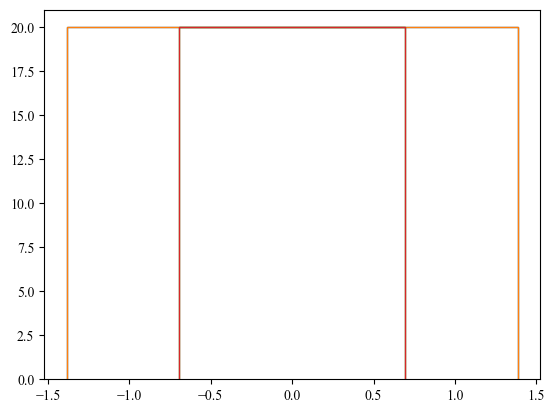

In [143]:
for i in range(6):
    if i > 1: _ = plt.hist((label_table[:,i]), bins=50, histtype='step')

In [144]:
corrfuncs1 = np.array(corrfuncs)
print("data shape",corrfuncs1.shape)
# Remove the missing rows
rmvd_label_table = np.delete(label_table, missing, axis=0)
# Duplicate each row to create a new array size (988,45,6)
raw_labels = np.repeat(rmvd_label_table[:, np.newaxis, :], 45, axis=1)
print("raw labels shape", raw_labels.shape)


print("alternative training")
corrfuncs2=np.reshape(corrfuncs1, (corrfuncs1.shape[0]*corrfuncs1.shape[1],corrfuncs1.shape[2]))
labels2 = np.reshape(raw_labels, (raw_labels.shape[0]*raw_labels.shape[1],raw_labels.shape[2]))
print(corrfuncs2.shape)
print(labels2.shape)

data shape (988, 45, 8)
raw labels shape (988, 45, 6)
alternative training
(44460, 8)
(44460, 6)


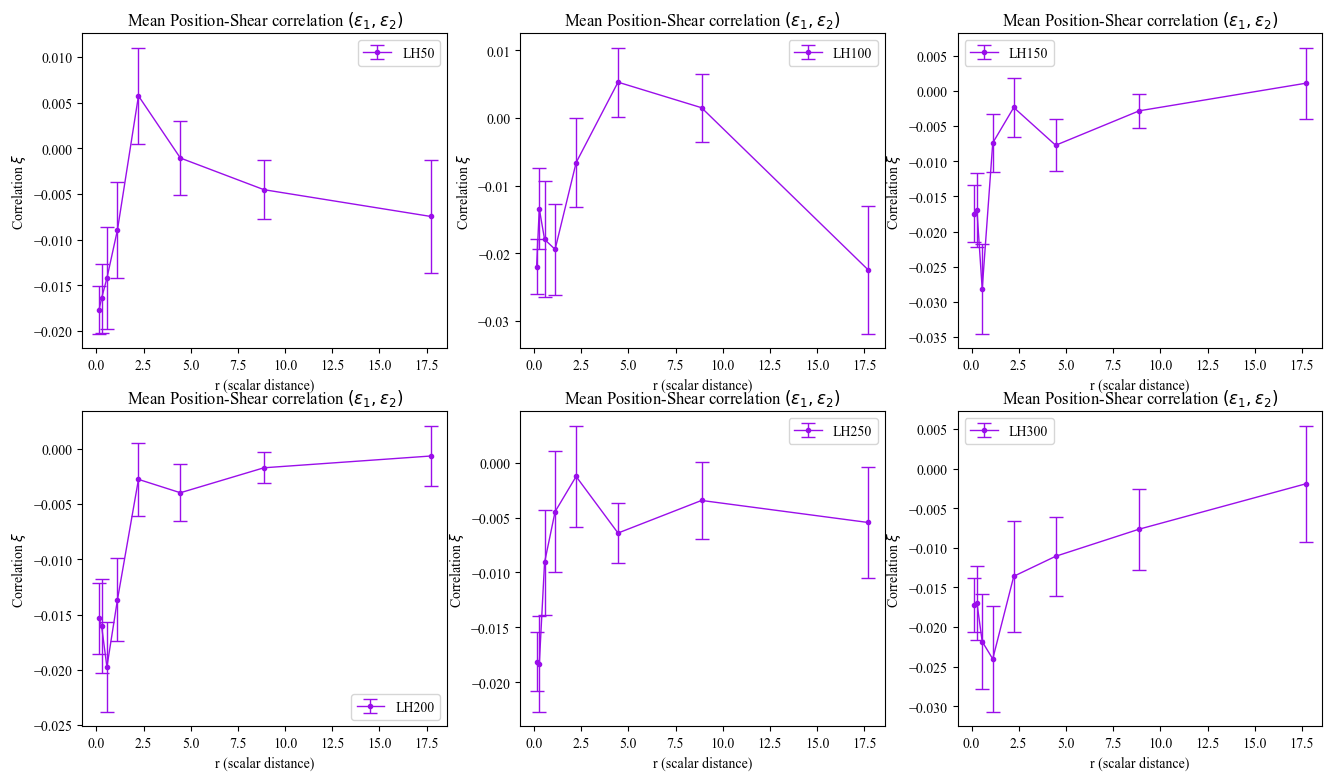

In [145]:
fig, ax = plt.subplots(2, 3,figsize=(16, 9))
k=0
for i in range(2):
    for j in range(3):
        sim_mean = np.mean(corrfuncs1[k],axis=0)
        sim_stderr = np.std(corrfuncs1[k],axis=0)/np.sqrt(45)
        k+=50
        ax[i,j].errorbar(r,sim_mean,sim_stderr,color='xkcd:violet',lw=1,
             label=f'LH{k}',capsize=5, elinewidth = 1, fmt = '.-')
        #ax[i,j].set_ylim([-0.035,0.01])
        ax[i,j].set_xlabel(r'r (scalar distance)')
        ax[i,j].set_ylabel(r'Correlation $\xi$')
        ax[i,j].set_title('Mean Position-Shear correlation $(\epsilon_1,\epsilon_2)$')
        ax[i,j].legend()

#### Bootstrap sampling

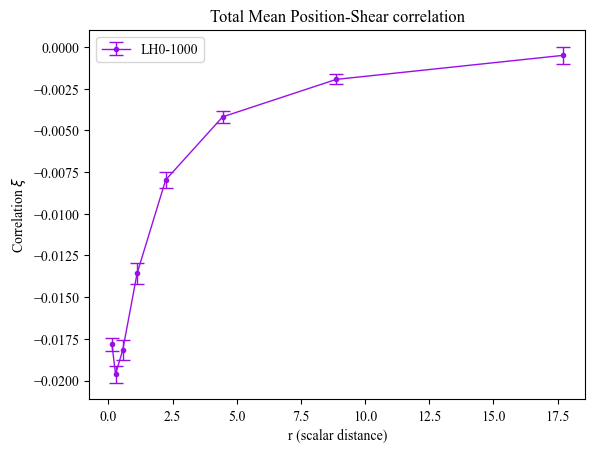

(100, 988, 8)


In [149]:
# Assuming you have your data in a numpy array named 'data' with shape (988, 45)
num_batches, batch_size, bins = corrfuncs1.shape
num_resamples = 100  # Number of bootstrap resamples

# Create an array to store the resampled means
resampled_means = np.empty((num_resamples, num_batches,bins))

# Perform bootstrap sampling and calculate means
for resample_idx in range(num_resamples):
    # Randomly sample indices with replacement for each batch
    sampled_indices = np.random.choice(batch_size, size=(num_batches, 30), replace=True)
    
    # Calculate means for each batch
    batch_means = np.mean(corrfuncs1[np.arange(num_batches)[:, np.newaxis], sampled_indices], axis=1)
    
    # Store the means in the resampled_means array
    resampled_means[resample_idx] = batch_means

# Calculate the mean and standard error of the resampled means
mean_of_means = np.mean(resampled_means, axis=0)
std_error_of_means = np.std(resampled_means, axis=0, ddof=1)  # Using Bessel's correction for sample standard deviation

# Print or use mean_of_means and std_error_of_means for machine learning
tot_mean = np.mean(mean_of_means,axis=0)
tot_sterr = np.mean(std_error_of_means,axis=0)/np.sqrt(num_resamples)
plt.errorbar(r,tot_mean,tot_sterr,color='xkcd:violet',lw=1,
             label=f'LH0-1000',capsize=5, elinewidth = 1, fmt = '.-')
plt.xlabel(r'r (scalar distance)')
plt.ylabel(r'Correlation $\xi$')
plt.title('Total Mean Position-Shear correlation')
plt.legend()
plt.show()
print(resampled_means.shape)


#### Splitting data

In [150]:
bootstr_data = resampled_means.reshape((resampled_means.shape[0]*resampled_means.shape[1],8))
print("bootstrapped data shape",bootstr_data.shape)

# Duplicate each row to create a new array size (988,45,6)
labels = np.repeat(rmvd_label_table[np.newaxis, :, :], num_resamples, axis=0)
bootstr_labels = labels.reshape((labels.shape[0]*labels.shape[1],6))
print("bootstrapped labels shape", bootstr_labels.shape)
# normalising labels
mean_labels = np.mean(bootstr_labels,axis=0)
std_labels = np.std(bootstr_labels,axis=0)
print(mean_labels)
print(std_labels)
bootstr_labels_n = (bootstr_labels-mean_labels) / (5*std_labels)  + 0.5 # mean of 0.5, std of 0.2
#print(bootstr_labels_n[:10])
# normalising data
mean_data = np.mean(bootstr_data,axis=0)
std_data = np.std(bootstr_data,axis=0)
print(mean_data)
print(std_data)
bootstr_data_n = (bootstr_data-mean_data)/(std_data*2)

bootstrapped data shape (98800, 8)
bootstrapped labels shape (98800, 6)
[ 3.02034008e-01  8.00725506e-01 -9.91742821e-03  1.59947277e-03
 -1.34415724e-03  3.74668998e-04]
[0.11464383 0.11555868 0.79892977 0.79841586 0.39992226 0.40067984]
[-0.0178212  -0.0196187  -0.01817575 -0.01358257 -0.00797337 -0.00418938
 -0.00194258 -0.00050313]
[0.007223   0.00860245 0.00970177 0.00984558 0.00785177 0.00585826
 0.00456008 0.00762507]


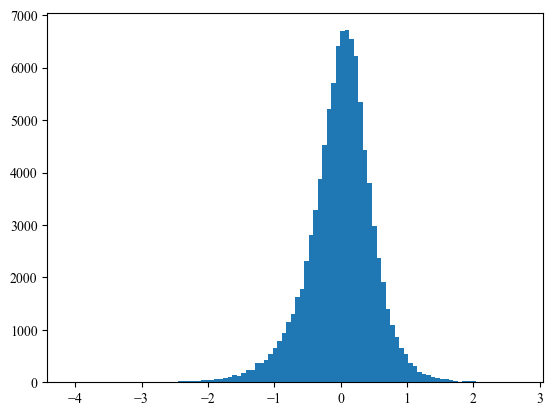

In [148]:
_= plt.hist(bootstr_data_n[:,5], bins=100)

In [7]:
# normalising labels & data withou bootstrap
mean_labels = np.mean(labels2,axis=0)
std_labels = np.std(labels2,axis=0)
print(mean_labels)
print(std_labels)
bootstr_labels_n = (labels2-mean_labels) / (5*std_labels)  + 0.5# mean of 0.5, std of 0.1
print(bootstr_labels_n[:10])
bootstr_data_n = corrfuncs2

[0.30203401 0.80072551 1.33934379 1.35287095 1.08048535 1.08262192]
[0.11464383 0.11555868 1.01645277 1.02098328 0.42569518 0.42693221]
[[0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]
 [0.51519051 0.8856796  0.93607442 0.44345379 0.25805143 0.17746523]]


(array([33000., 17000., 11200.,  8500.,  6900.,  5800.,  4800.,  4400.,
         3700.,  3500.]),
 array([0.28572663, 0.35939676, 0.43306688, 0.506737  , 0.58040712,
        0.65407725, 0.72774737, 0.80141749, 0.87508761, 0.94875773,
        1.02242786]),
 <BarContainer object of 10 artists>)

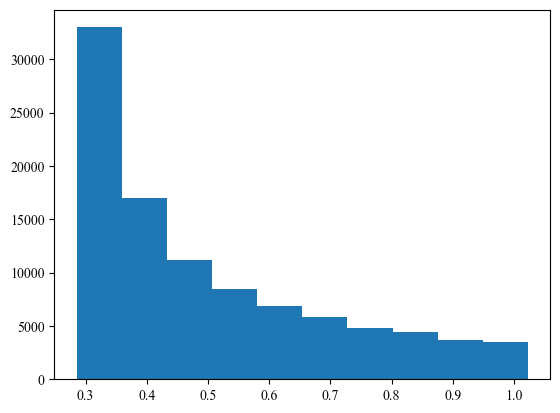

In [81]:
plt.hist(bootstr_labels_n[:,2])

In [151]:
train_data, test_data, train_label, test_label = train_test_split(bootstr_data_n, bootstr_labels_n, test_size = 0.1, random_state = 6)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.11, random_state = 6)
print(test_data.shape, test_label.shape)
print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)

(9880, 8) (9880, 6)
(79138, 8) (79138, 6)
(9782, 8) (9782, 6)


#### Build Model

In [152]:
# normalizer = tf.keras.layers.Normalization(axis=-1, input_shape=(8,))
# normalizer.adapt(train_data)
# mean_value = normalizer.mean.numpy()
# variance_value = normalizer.variance.numpy()
# print("Input Normalization Mean:", mean_value)
# print("Input Normalization Variance:", variance_value)

In [155]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(50, input_shape=(8,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(50, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))
model.build()
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 50)                450       
                                                                 
 dense_113 (Dense)           (None, 50)                2550      
                                                                 
 dense_114 (Dense)           (None, 32)                1632      
                                                                 
 dense_115 (Dense)           (None, 8)                 264       
                                                                 
 dense_116 (Dense)           (None, 1)                 9         
                                                                 
 dense_117 (Dense)           (None, 1)                 2         
                                                                 
Total params: 4,907
Trainable params: 4,907
Non-train

In [156]:
param=4
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=20,batch_size=32,verbose=1,validation_data=(val_data,val_label[:,param]))
print()

309/309 [==============================] - 1s 2ms/step
Epoch 1/20
2474/2474 [==============================] - 8s 3ms/step - loss: 0.0314 - val_loss: 0.0313
Epoch 2/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0306 - val_loss: 0.0310
Epoch 3/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0304 - val_loss: 0.0310
Epoch 4/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0302 - val_loss: 0.0313
Epoch 5/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0301 - val_loss: 0.0309
Epoch 6/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0300 - val_loss: 0.0306
Epoch 7/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0299 - val_loss: 0.0307
Epoch 8/20
2474/2474 [==============================] - 6s 3ms/step - loss: 0.0299 - val_loss: 0.0306
Epoch 9/20
2474/2474 [==============================] - 6s 2ms/step - loss: 0.0298 - val_loss: 0.0305
Epoch 10/20
2474/2474 [====

End validation loss is: 0.030436202883720398


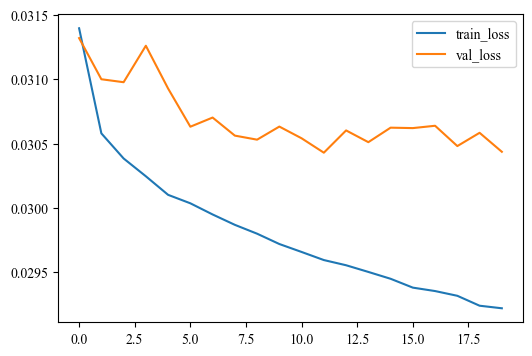

In [157]:
print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

309/309 [==============================] - 1s 2ms/step


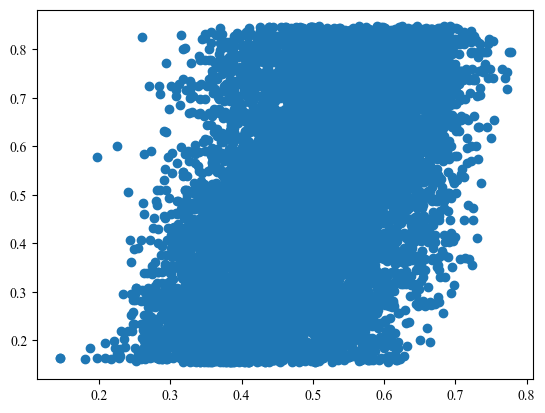

In [158]:

test_predict=model.predict(test_data, verbose=1)
plt.scatter(test_predict,test_label[:,param])

In [159]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.5,2.0],[0.5,2.0],[0.5,2.0]]

test_predict=model.predict(test_data, verbose=1)

pre_predict = (pre_test_predict - 0.5)*5*std_labels[param] + mean_labels[param]
predict = (test_predict - 0.5)*5*std_labels[param] + mean_labels[param]
actual = (test_label[:,param] - 0.5)*5*std_labels[param] + mean_labels[param]

309/309 [==============================] - 1s 2ms/step


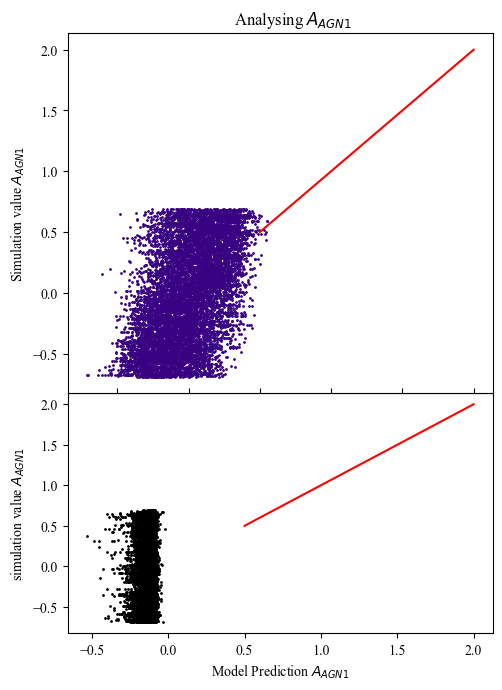

In [162]:
fig = plt.figure(figsize=(5, 8))
fig.suptitle(f"Analysing ${simpars[param]}$")
gs = GridSpec(5, 10, figure=fig)

ax2 = fig.add_subplot(gs[3:5, :10])
ax1 = fig.add_subplot(gs[:3, :10])

ax1.scatter(predict, actual, marker='o', s=1, alpha=1.0, c='xkcd:indigo')
ax1.plot(lims[param],lims[param],c='r')
#ax1.set_xlabel(f'Model Prediction ${simpars[param]}$')
ax1.set_ylabel(f'Simulation value ${simpars[param]}$')
# ax1.set_xlim(lims[param])#+np.array([-0.1,0.1]))
# ax1.set_ylim(lims[param]+np.array([-0.02,0.02]))
ax1.tick_params(axis="x",direction="in",labelbottom=False)

ax2.scatter(pre_predict[:,0], actual, marker='o', s=1, alpha=1.0, c='k')
#ax2.hist2d(pre_predict[:,0], actual, cmap='Purples', norm=colors.LogNorm(), bins=64)
ax2.plot(lims[param],lims[param],c='r')
ax2.set_xlabel(f'Model Prediction ${simpars[param]}$')
ax2.set_ylabel(f'simulation value ${simpars[param]}$')
# ax2.set_xlim(lims[param])#+np.array([-0.1,0.1]))
# ax2.set_ylim(lims[param]+np.array([-0.02,0.02]))


plt.subplots_adjust(left=0.05,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.95, 
                    hspace=0.0)  #Ad

In [ ]:
plt.hist2d(pre_predict[:,0], actual, cmap='Purples', norm=colors.LogNorm(), bins=64)
plt.scatter(predict, actual, marker='o', s=1, alpha=1.0, c='xkcd:indigo')
plt.plot(lims[param],lims[param],c='r')
plt.xlabel(f'Model Prediction ${simpars[param]}$')
plt.ylabel(f'parameter value ${simpars[param]}$')
plt.xlim(lims[param])#+np.array([-0.1,0.1]))
plt.ylim(lims[param]+np.array([-0.02,0.02]))

In [29]:
model.evaluate(train_data, train_label[:,param], verbose=0)

0.061427656561136246